In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from math import floor


import json
from pprint import pprint

In [2]:
def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [3]:
json_path="./data_balancers_border.json"
with open(json_path) as f:
    data = json.load(f)

In [4]:
prediction = []
naive = []

for d in data["datapoints"]:
    s = d["setting"]
    comp_time = list(map(lambda x: x["computationTime"],
                   d["data"]["workers"]))
    if s["balancer"] == "predictionRecursive":
        prediction += comp_time
    elif s["balancer"] == "naiveRecursive":
        naive += comp_time
     

# time in s
prediction = np.asarray(prediction) / 1e6
naive = np.asarray(naive) / 1e6
print(prediction, naive)

[ 3.036703  5.191414  6.752637  8.010456  8.039306  8.06284   8.636381
  9.086251  9.527374 10.798302 10.798988 12.490375 15.810545 15.950091
 16.281443 17.256162 19.467921  7.195978  7.727826  7.814889  7.839242
  8.274062  9.036633  9.749593  9.965702 10.922917 10.937547 10.932986
 10.945138 12.763388 13.34328  14.522943 15.572464 26.921217  8.034465
 10.674801 11.754949 12.262449 13.059056 13.537251 14.288163 15.334759
 15.617321 16.055714 16.051892 16.792414 17.231759 22.045298 23.118204
 24.606632 25.539461  3.036542  5.182143  6.604552  8.01142   8.039073
  8.0627    8.624781  9.08653   9.527059 10.796948 10.796373 12.489961
 15.809889 15.945367 15.959657 17.252842 19.466212  7.194754  7.664478
  7.725173  7.813065  8.272378  9.036648  9.534036  9.968197 10.921218
 10.92706  10.934589 10.951638 12.761227 13.043654 14.530653 15.581525
 26.920978  8.034014 10.680008 11.761882 12.262108 13.053984 13.538888
 14.2889   15.337859 15.618582 16.050453 16.046981 16.79191  17.235113
 22.04

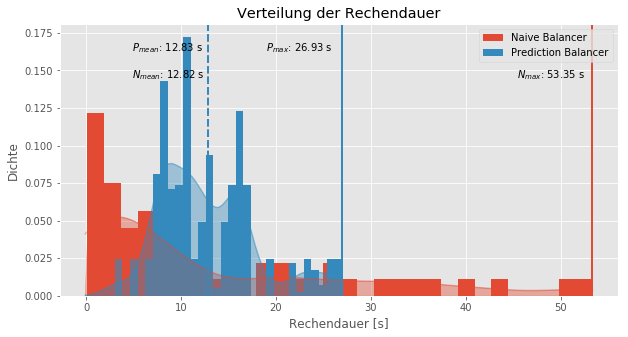

In [17]:
# Data for plotting
def histogram(y_data1, y1_label, y_data2, y2_label, 
              x_label, y_label, title):
    num_bins = 30
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # weights1 = np.ones_like(y_data1)/float(len(y_data1))
    # weights2 = np.ones_like(y_data2)/float(len(y_data2))
    # interval = (min(y_data1.min(), y_data2.min()),max(y_data1.max(), y_data2.max()))

    # draw histogram
    _, _, y1_patches = ax.hist(y_data1, num_bins, density=1, # range=interval, weights=weights1, 
            label=y1_label, alpha=1)
    _, _, y2_patches = ax.hist(y_data2, num_bins, density=1, # range=interval, weights=weights2,   
            label=y2_label, alpha=1)

    y1_color = y1_patches[0].get_facecolor()
    y2_color = y2_patches[0].get_facecolor()

    ax.legend()
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(True)

    def drawKDE(ax, data, color):
        # plot kernel density estimate
        density = gaussian_kde(data)
        xs = np.linspace(-0.1, data.max(), 200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ys = density(xs)

        alpha=0.4
        kde_line = ax.plot(xs, ys, alpha=alpha)
        kde_line[0].set_color(color)
        # TODO: Find a better way to do this
        ys[0] = 0
        ys[-1] = 0
        
        kde_fill = ax.fill(xs, ys, alpha=alpha)
        kde_fill[0].set_color(color)

    drawKDE(ax, y_data1, y1_color)
    drawKDE(ax, y_data2, y2_color)
    #  median
    y1_mean = y_data1.mean()
    y1_max = y_data1.max()
    y2_mean = y_data2.mean()
    y2_max = y_data2.max()
    
    def drawLine(ax, x, label, y_offset, color, style):
        ax.axvline(x, linestyle=style, lw=2, color=color)
        _, max_ = plt.ylim()
        plt.text(x-  8, 
             max_ - max_* y_offset/ 10, 
             label + ': {:.2f} s'.format(x))
        
    drawLine(ax, y1_mean, "$N_{mean}$",
             2,
             y1_color, 'dashed')
    drawLine(ax, y1_max, "$N_{max}$",
             2,
             y1_color, 'solid')
    drawLine(ax, y2_mean, "$P_{mean}$", 
             1,
             y2_color, 'dashed')
    drawLine(ax, y2_max, "$P_{max}$", 
             1,
             y2_color, 'solid')
           

    save_fig(fig, "distribution")
    plt.show()
    
histogram(naive,
          "Naive Balancer",
          prediction,
          "Prediction Balancer",
          x_label='Rechendauer [s]',
          y_label='Dichte',
          title='Verteilung der Rechendauer')


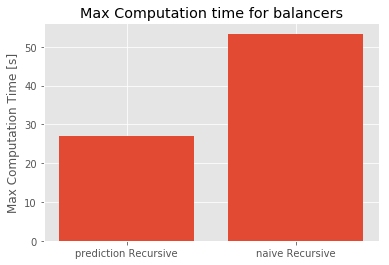

In [6]:
names= ["prediction Recursive", "naive Recursive"]
y = np.asarray([prediction.max(), naive.max()])
x = np.arange(len(y))

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set(ylabel='Max Computation Time [s]',
      title='Max Computation time for balancers')
ax.grid(True)
plt.show()